# Introduction: A Retreival Augmented Generation (RAG)-based AI assistant

#### We use Retreival Augmented Generation (RAG) to answer questions on the document(s) using an LLM
#### In this notebook we go through the following steps:

1. Collect the document(s) from different webpages in the website: We choose to build an AI assistant on the history of Bengal, so we pick the relevant pages from wikipedia
2. Split the document(s) into chunks -- could be the original pages themselves
3. Transform the chunks into embedding vectors 
3. Create a FAISS vector database with the chunks and embeddings
4. Query the database with a question, and retrieve the most relevant chunks, which we call context
5. Combine a "system prompt" and the context to create a query for the LLM
6. Generate an answer from the LLM using this query

#### - Large Language Model used: Gemma2B 
#### - Embedding Model used: bge-small-en-v1.5
#### - Reranker model.  Consider 'BAAI/bge-reranker-large'





## Define wikipedia categories (all pages within these categories will be used)
As we want to answer questions on the history of Bengal, we choose the following categories

In [ ]:
categories = ["History_of_Bengal", "History of Bangladesh", "Bengal Renaissance",
             "History of Kolkata", "History of West Bengal" ]

# Pip install packages 

In [2]:
%%time
%%capture
!pip install tiktoken FlagEmbedding transformers faiss-gpu
!pip install sentence_transformers
!pip install -q -U wikipedia-api
#!pip install requests bs4

CPU times: user 107 ms, sys: 35.4 ms, total: 143 ms
Wall time: 45.1 s


# Obtain the wikipedia pages for a given topic

In [3]:
from tqdm import tqdm
import wikipediaapi
import re

# Pre-compile the regular expression pattern for better performance
BRACES_PATTERN = re.compile(r'\{.*?\}|\}')

def remove_braces_and_content(text):
    """Remove all occurrences of curly braces and their content from the given text"""
    return BRACES_PATTERN.sub('', text)

def clean_string(input_string):
    """Clean the input string."""
    
    # Remove extra spaces by splitting the string by spaces and joining back together
    cleaned_string = ' '.join(input_string.split())
    
    # Remove consecutive carriage return characters until there are no more consecutive occurrences
    cleaned_string = re.sub(r'\r+', '\r', cleaned_string)
    
    # Remove all occurrences of curly braces and their content from the cleaned string
    cleaned_string = remove_braces_and_content(cleaned_string)
    
    # Return the cleaned string
    return cleaned_string

def extract_wiki(wiki, category_name):
    """Extract all references from a category on Wikipedia"""
    
    # Get the Wikipedia page corresponding to the provided category name
    category = wiki.page("Category:" + category_name)
    
    # Initialize an empty list to store page titles
    pages = []
    
    # Check if the category exists
    if category.exists():
        # Iterate through each article in the category and append its title to the list
        for article in category.categorymembers.values():
            pages.append(article.title)
    
    # Return the list of page titles
    return pages


def get_wiki(categories):
    """Retrieve Wikipedia pages from a list of categories and extract their content"""
    
    # Create a Wikipedia object
    wiki_wiki = wikipediaapi.Wikipedia('AI_Assistant', 'en')
    
    # Initialize lists to store explored categories and Wikipedia pages
    explored_categories = []
    wikipedia_pages = []

    # Iterate through each category
    print("- Processing Wikipedia categories:")
    for category_name in categories:
        print(f"\tExploring {category_name} on Wikipedia")
        
        # Get the Wikipedia page corresponding to the category
        category = wiki_wiki.page("Category:" + category_name)
        
        # Extract Wikipedia pages from the category and extend the list
        wikipedia_pages.extend(extract_wiki(wiki_wiki, category_name))
        
        # Add the explored category to the list
        explored_categories.append(category_name)

    # Extract subcategories and remove duplicate categories
    categories_to_explore = [item.replace("Category:", "") for item in wikipedia_pages if "Category:" in item]
    wikipedia_pages = list(set([item for item in wikipedia_pages if "Category:" not in item]))
    
    # Explore subcategories recursively
    while categories_to_explore:
        category_name = categories_to_explore.pop()
        print(f"\tExploring {category_name} on Wikipedia")
        
        # Extract more references from the subcategory
        more_refs = extract_wiki(wiki_wiki, category_name)

        # Iterate through the references
        for ref in more_refs:
            # Check if the reference is a category
            if "Category:" in ref:
                new_category = ref.replace("Category:", "")
                # Add the new category to the explored categories list
                if new_category not in explored_categories:
                    explored_categories.append(new_category)
            else:
                # Add the reference to the Wikipedia pages list
                if ref not in wikipedia_pages:
                    wikipedia_pages.append(ref)

    # Initialize a list to store extracted texts
    extracted_texts = []
    
    # Iterate through each Wikipedia page
    print("- Processing Wikipedia pages:")
    for page_title in tqdm(wikipedia_pages):
        try:
            # Make a request to the Wikipedia page
            page = wiki_wiki.page(page_title)

            # Check if the page summary does not contain certain keywords
            if "Biden" not in page.summary and "Trump" not in page.summary:
                # Append the page title and summary to the extracted texts list
                if len(page.summary) > len(page.title):
                    extracted_texts.append(page.title + " : " + clean_string(page.summary))

                # Iterate through the sections in the page
                for section in page.sections:
                    # Append the page title and section text to the extracted texts list
                    if len(section.text) > len(page.title):
                        extracted_texts.append(page.title + " : " + clean_string(section.text))
                        
        except Exception as e:
            print(f"Error processing page {page.title}: {e}")
                    
    # Return the extracted texts
    return extracted_texts

In [ ]:
# collect all the pages under these categories....
extracted_texts = get_wiki(categories)
print("Found", len(extracted_texts), "Wikipedia pages")

- Processing Wikipedia categories:
	Exploring History_of_Bengal on Wikipedia
	Exploring History of Bangladesh on Wikipedia
	Exploring Bengal Renaissance on Wikipedia
	Exploring History of Kolkata on Wikipedia
	Exploring History of West Bengal on Wikipedia
	Exploring History of rail transport in West Bengal on Wikipedia
	Exploring Palaces in West Bengal on Wikipedia
	Exploring Medieval Bengal on Wikipedia
	Exploring History of Kolkata on Wikipedia
	Exploring Forts in West Bengal on Wikipedia
	Exploring Former districts of West Bengal on Wikipedia
	Exploring Disasters in West Bengal on Wikipedia
	Exploring Colonial Bengal on Wikipedia
	Exploring History of Cooch Behar on Wikipedia
	Exploring Bengal Subah on Wikipedia
	Exploring Archaeological sites in West Bengal on Wikipedia
	Exploring Ancient Bengal on Wikipedia
	Exploring History of West Bengal (1947–present) on Wikipedia
	Exploring Military history of Kolkata on Wikipedia
	Exploring Decades in Kolkata on Wikipedia
	Exploring Centurie

100%|██████████| 635/635 [00:55<00:00, 11.52it/s]

Found 657 Wikipedia pages


In [10]:
#### Dump the texts for future use 

import pickle
with open("bengal_history_wikidump.pickle", 'wb') as file:
    pickle.dump(extracted_texts, file)

# Reformat text chunks

#### How large are the chunks on average?

Average number of characters per chunk : 5800.86


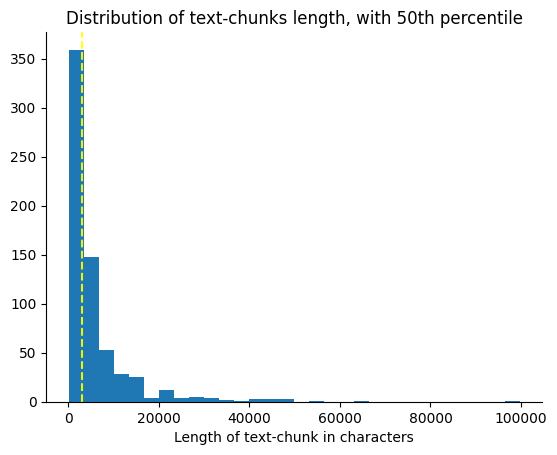

In [11]:
import numpy as np
from matplotlib import pyplot as plt

chunks_sizes = [len(chunk) for chunk in extracted_texts]
print("Average number of characters per chunk : ""%.2f" % np.mean(chunks_sizes))

percentile_50th = np.percentile(chunks_sizes, 50)
plt.hist(chunks_sizes, bins=30)
plt.title('Distribution of text-chunks length, with 50th percentile')
plt.xlabel('Length of text-chunk in characters')
plt.axvline(x = percentile_50th, color = 'yellow', linestyle = '--', alpha = 0.9)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show();


In [12]:
def split_text_chunks(strings, K, L):
    result = []
    for string in strings:
        if len(string) > K:
            i = 0
            while i < len(string):
                result.append(string[i:i+K])
                i += K - L
        else:
            result.append(string)
    return result

Average number of characters per chunk : 1727.08


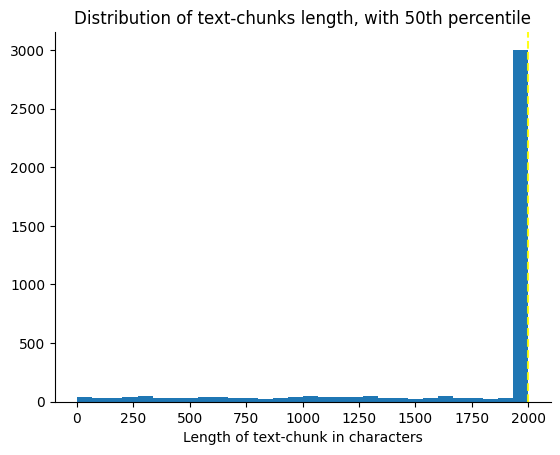

In [13]:
new_chunks = split_text_chunks(extracted_texts, K=2000, L =1000)

chunks_sizes = [len(chunk) for chunk in new_chunks]
print("Average number of characters per chunk : ""%.2f" % np.mean(chunks_sizes))

percentile_50th = np.percentile(chunks_sizes, 50)
plt.hist(chunks_sizes, bins=30)
plt.title('Distribution of text-chunks length, with 50th percentile')
plt.xlabel('Length of text-chunk in characters')
plt.axvline(x = percentile_50th, color = 'yellow', linestyle = '--', alpha = 0.9)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show();


In [15]:
len(new_chunks)
#len(extracted_texts)

4038

# Build a vector database using an embedding model


#### Download an embedding model. We consider 'BAAI/bge-small-en-v1.5' 
- The Embedding model will transform the text chunks into numerical vectors in high-dimensions
- Embedding vectors corresponding to text chunks similar in meaning (semantics) to each other, are closer to each other in the vector space
- Next we use FAISS to build a vector database

In [16]:
%%time
# Load a pre-trained sentence transformer model
from sentence_transformers import SentenceTransformer, util
import faiss
from transformers import AutoTokenizer, AutoModel
import torch
#model = SentenceTransformer('all-MiniLM-L6-v2')
model = SentenceTransformer('BAAI/bge-small-en-v1.5') 
                            
# Function to embed text chunks
def embed_text_chunks(text_chunks, model):
    embeddings = model.encode(text_chunks, convert_to_tensor=True, device='cuda')
    cpu_embeddings = embeddings.cpu().numpy()
    del embeddings
    embeddings = None
    torch.cuda.empty_cache()
    return cpu_embeddings

# Function to create FAISS index
def create_faiss_index(text_chunks, model):
    embeddings = embed_text_chunks(text_chunks, model)
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(embeddings)
    del embeddings
    return index

# Create the FAISS index
faiss_index = create_faiss_index(new_chunks, model)

/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-07-19 23:12:37.117677: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 23:12:37.117848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 23:12:37.250903: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/127 [00:00<?, ?it/s]

CPU times: user 39 s, sys: 2.48 s, total: 41.5 s
Wall time: 44.8 s


In [17]:
torch.cuda.empty_cache()

#### Download the reranker model.  Consider 'BAAI/bge-reranker-large'
- A query on the embedding vectors returns chunks that are most relevant to the query
- A reranker is used to further evaluate these chunks, based on certain criteria 
- It reorders or "re-ranks" them according to their quality or relevance

In [18]:
%%time
from FlagEmbedding import FlagReranker
reranker = FlagReranker('BAAI/bge-reranker-large', use_fp16=True) # Setting use_fp16 to True speeds up computation with a slight performance degradation

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

CPU times: user 5.88 s, sys: 5.62 s, total: 11.5 s
Wall time: 42.5 s


In [19]:
# Function to search the FAISS index
def query_faiss(query_text, index, model, k=5):
    query_embedding = model.encode([query_text], convert_to_tensor=True, device='cuda').cpu().numpy()
    distances, indices = index.search(query_embedding, k)
    return distances, indices




# Load the Large Language Model and Query

- We use Gemma2B, a pretrained lightweight LLM wih 2 billion parameters, released by Google 


In [20]:
%%time

language_model_name = "/kaggle/input/gemma/transformers/2b-it/3" #"
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained(language_model_name, use_fast = True)
language_model = AutoModelForCausalLM.from_pretrained(language_model_name, 
                            device_map="cuda",  # change this to "auto" if you want to run the LLM distributed on 2 GPUs, 
                             trust_remote_code=False,
                                             revision="main")
language_model.config.hidden_activation = 'gelu_pytorch_tanh'


### insert your code here!
print('Done loading model: '+ language_model_name)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Done loading model: /kaggle/input/gemma/transformers/2b-it/3
CPU times: user 8.04 s, sys: 7.84 s, total: 15.9 s
Wall time: 35.4 s


#### Specify system prompt


In [21]:
system_message =  """You are a helpful AI tutor who is an expert on Bengal History.
Answer the question using the context provided.
Add as many details as possible
"""


#### Specify the query, aka question we want to ask
- Some example questions


In [31]:

query1 = "Who was Shashanka?" 
query2 = "When did the partition of Bengal take place?" 
query3 = "Who founded Young Bengal?" 
query4 = "When was Mujibur Rahaman assassinated?" 
query5 = "What is Rabindranath Tagore famous for?"
query6 = "Where was the Portuguese trading posts in Bengal?"
query7 = "Who founded the Pala Empire?" 
query8 = "What was thw religion of the Pala Empire?"
query9 =  "How did Islam spread in Bengal?"
query10 = "What was the Brahmo movement?"

query_list = [query1, query2, query3, query4, query5, query6, query7, query8, query9, query10]

#### Can the LLM answer these questions without RAG?
- Not really! Most answers in fact are garbage

In [32]:
%%time
for query in query_list:
    input_ids = tokenizer(query, return_tensors="pt").to("cuda")

    outputs = language_model.generate(**input_ids, max_new_tokens = 1024, do_sample = True, top_k = 5, top_p = 0.1, temperature = 0.1)
    full_answer = tokenizer.decode(outputs[0])
    torch.cuda.empty_cache()
    print(full_answer)
    

<bos>Who was Shashanka?

Shashanka was a legendary king of the ancient city of Patala, India. He was known for his military prowess and his ability to defeat the powerful army of the demon king Ravana. Shashanka was also a wise and just ruler who was known for his generosity and his kindness.<eos>
<bos>When did the partition of Bengal take place?

The partition of Bengal took place between 1947 and 1949.<eos>
<bos>Who founded Young Bengal?

Young Bengal is a political and social organization in India. It was founded in 1903 by **Bankim Chandra Chatterjee**.<eos>
<bos>When was Mujibur Rahaman assassinated?

There is no evidence to support the claim that Mujibur Rahaman was assassinated.<eos>
<bos>What is Rabindranath Tagore famous for?

Rabindranath Tagore is a renowned poet, songwriter, composer, and Nobel laureate. He is considered one of the greatest poets of the 20th century. His works have been translated into more than 50 languages and continue to inspire and influence people worl

#### query the vector database to identify matching chunks

- We choose the top 5 best matching chunks (this number could be something else as well, by varying the n_results parameter)

#### context_chunks_init are the chunks with relevant context (with regards to the query)

- We will use the reranker to sort these chunks based on relevance

#### Keep the "best" chunks that are the most relevant as per the reranker
 - Use a threshold
 
 #### Query the LLM with the full query, with system_message, context and query

In [33]:
%%time
n_top_matches = 5

for query in query_list:
    
    distances, indices = query_faiss(query, faiss_index, model, k = n_top_matches)
    #print(distances)
    context_chunks_init = []
    for i in range(n_top_matches):
        context_chunks_init.append(new_chunks[indices[0][i]])

    #make pairs of query and chunks
    query_and_chunks = [[query, chunk] for chunk in context_chunks_init]
    scores_reranker = reranker.compute_score(query_and_chunks)
    #print("Scores of retrieved chunks:\n", np.round(  scores_reranker, decimals =2))
    # indexes sorted according to new rank
    #print("\nOld order of retrieved chunks:", np.arange(n_top_matches))
    max_idx_reranked = np.argsort(-np.array(scores_reranker))
    #print("\nRe-ranked order of retrieved chunks:", max_idx_reranked)

    cut_off_score = 0
    min_score = np.max(scores_reranker)
    # if np.max(scores_reranker) > cut_off_score:
    #     cut_off_score = 3

    context_chunks = []
    for idx in max_idx_reranked:
        if scores_reranker[idx] >= min_score:
            context_chunks.append(context_chunks_init[idx])

    prompt_template = system_message + """\n\n\nContext:
    {context}

    Question: {question}

    Answer:"""

    context_chunks_as_str = '\n###\n'.join([str(elem) for elem in context_chunks])
    llm_full_query = prompt_template.format(context=context_chunks_as_str, question=query)


    input_ids = tokenizer(llm_full_query, return_tensors="pt").to("cuda")

    outputs = language_model.generate(**input_ids, max_new_tokens = 1024, do_sample = True, top_k = 5, top_p = 0.1, temperature = 0.1)
    full_answer = tokenizer.decode(outputs[0])

    printed_answer = full_answer.split("Answer:")[1]
    printed_answer = printed_answer.split("<eos>")[0]
    print("\nQuestion:" + query+"\n")
    print(printed_answer)

    torch.cuda.empty_cache()

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Question:Who was Shashanka?

 Shashanka was the first independent king of a unified polity in the Bengal region, called the Gauda Kingdom. He reigned in the 7th century, some historians place his rule between c. 600 and 636/7 CE, whereas other sources place his reign between 590 and 625 CE.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Question:When did the partition of Bengal take place?

 The partition of Bengal took place in 1947.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Question:Who founded Young Bengal?

 Henry Louis Vivian Derozio founded the Young Bengal Movement.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Question:When was Mujibur Rahaman assassinated?

 15 August 1975.

    Details: Mujibur Rahaman was assassinated by a group of junior army rebels on 15 August 1975.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Question:What is Rabindranath Tagore famous for?

 Rabindranath Tagore is famous for his profoundly sensitive, fresh and beautiful poetry of Gitanjali, in 1913 Tagore became the first non-European and the first lyricist to win the Nobel Prize in Literature.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Question:Where was the Portuguese trading posts in Bengal?

 The Portuguese trading posts in Bengal were established at Hooghly, Chinsura, Serampore, and Calcutta.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Question:Who founded the Pala Empire?

 The Pala Empire was founded with the election of Gopāla as the emperor of Gauda in late eighth century CE.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Question:What was thw religion of the Pala Empire?

 The Pala Empire was the first independent Buddhist dynasty of Bengal.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Question:How did Islam spread in Bengal?

 Islam spread in Bengal because of its localisation. Islamic agencies were inserted into the contemporary cosmology, were then associated with local divinities and eventually the Islamic agencies took over the local culture.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Question:What was the Brahmo movement?

 The Brahmo movement was a Hindu religious movement which originated from the mid-19th century Bengali Renaissance, the nascent Indian independence movement.
CPU times: user 16 s, sys: 302 ms, total: 16.3 s
Wall time: 16.2 s
